In [1]:
import tensorflow as tf
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from keras.callbacks import EarlyStopping

import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
%load_ext tensorboard

In [2]:
image_size = 300
batch_size = 16

In [3]:
train_folder = "../../datasets/vegetation/train"
test_folder = "../../datasets/vegetation/test"

In [4]:
dataset= tf.keras.utils.image_dataset_from_directory(
  train_folder,
  seed=123,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 17117 files belonging to 5 classes.


In [5]:
train_datagen = ImageDataGenerator(
   rescale=1./255,
   shear_range=0.2,
   zoom_range=0.2,
   horizontal_flip=True
)

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
   train_folder,
   target_size=(image_size, image_size),
   batch_size=batch_size,
   class_mode='categorical',
   color_mode='rgb',
   shuffle=True
)

Found 17117 images belonging to 5 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(
   test_folder,
   target_size=(image_size, image_size),
   batch_size=batch_size,
   class_mode='categorical',
   color_mode='rgb'
)

Found 4280 images belonging to 5 classes.


In [9]:
class_names = dataset.class_names
print(class_names)

['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']


In [10]:
base_model = tf.keras.applications.EfficientNetV2S(
   weights='imagenet',
   input_shape=(image_size, image_size, 3),
   include_top=False
)

In [11]:
base_model.trainable = True

In [12]:
model = tf.keras.Sequential([
   base_model,
   layers.GlobalAveragePooling2D(),
   layers.Dense(1024, activation='relu'),
   layers.Dropout(0.5),
   layers.Dense(len(class_names), activation='softmax'),
])

In [13]:
from tensorflow.keras.optimizers import Adam
adam_opt = Adam(learning_rate=0.0001)

model.compile(
   optimizer=adam_opt,
   loss='categorical_crossentropy',
   metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 10, 10, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 21,648,229
Trainable params: 21,494,357
No

In [15]:
epochs = 100

In [16]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
history = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=epochs,
  callbacks=[
    tensorboard_callback,
    EarlyStopping(monitor='val_loss', patience=10)
  ]
)

Epoch 1/100
1070/1070 [==============================] - 403s 354ms/step - loss: 0.6032 - accuracy: 0.7803 - val_loss: 0.4212 - val_accuracy: 0.8568
Epoch 2/100
1070/1070 [==============================] - 371s 347ms/step - loss: 0.4169 - accuracy: 0.8509 - val_loss: 0.3742 - val_accuracy: 0.8633
Epoch 3/100
1070/1070 [==============================] - 361s 338ms/step - loss: 0.3444 - accuracy: 0.8747 - val_loss: 0.3979 - val_accuracy: 0.8734
Epoch 4/100
1070/1070 [==============================] - 346s 323ms/step - loss: 0.2965 - accuracy: 0.8937 - val_loss: 0.3550 - val_accuracy: 0.8834
Epoch 5/100
1070/1070 [==============================] - 346s 323ms/step - loss: 0.2479 - accuracy: 0.9113 - val_loss: 0.3675 - val_accuracy: 0.8724
Epoch 6/100
1070/1070 [==============================] - 346s 323ms/step - loss: 0.2149 - accuracy: 0.9241 - val_loss: 0.3955 - val_accuracy: 0.8766
Epoch 7/100
1070/1070 [==============================] - 365s 341ms/step - loss: 0.1737 - accuracy: 0.9387

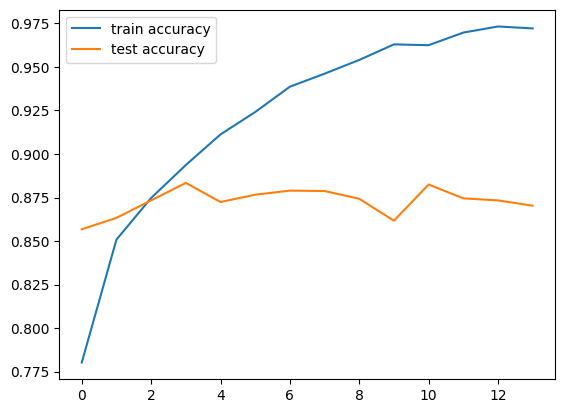

In [18]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.legend()
plt.show()

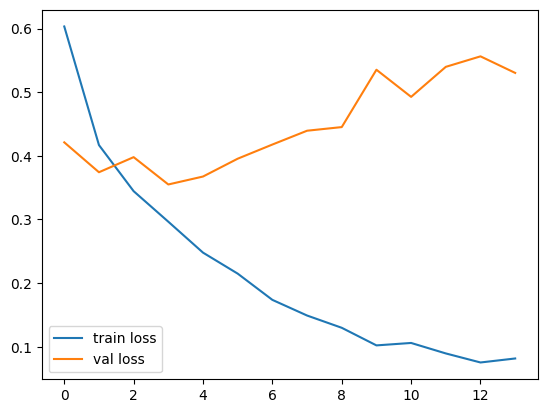

In [19]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

In [20]:
# Save the model
model.save('efficientnetv2_model.h5')

In [24]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the saved model
model = load_model('efficientnetv2_model.h5')

In [25]:
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False  # Ensure the order of images is preserved
)


Found 4280 images belonging to 5 classes.


In [26]:
# Get the predictions
predictions = model.predict(test_generator)

# Convert probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

# Get class names
class_labels = list(test_generator.class_indices.keys())


268/268 [==============================] - 23s 72ms/step


In [27]:
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

         CBB       0.53      0.59      0.56       218
        CBSD       0.82      0.73      0.77       438
         CGM       0.74      0.80      0.77       477
         CMD       0.96      0.95      0.96      2631
     Healthy       0.75      0.76      0.76       516

    accuracy                           0.87      4280
   macro avg       0.76      0.77      0.76      4280
weighted avg       0.87      0.87      0.87      4280



Confusion Matrix:
[[ 129   19   12   12   46]
 [  35  319   19   38   27]
 [  13    5  380   42   37]
 [  17   13   77 2506   18]
 [  48   33   26   18  391]]


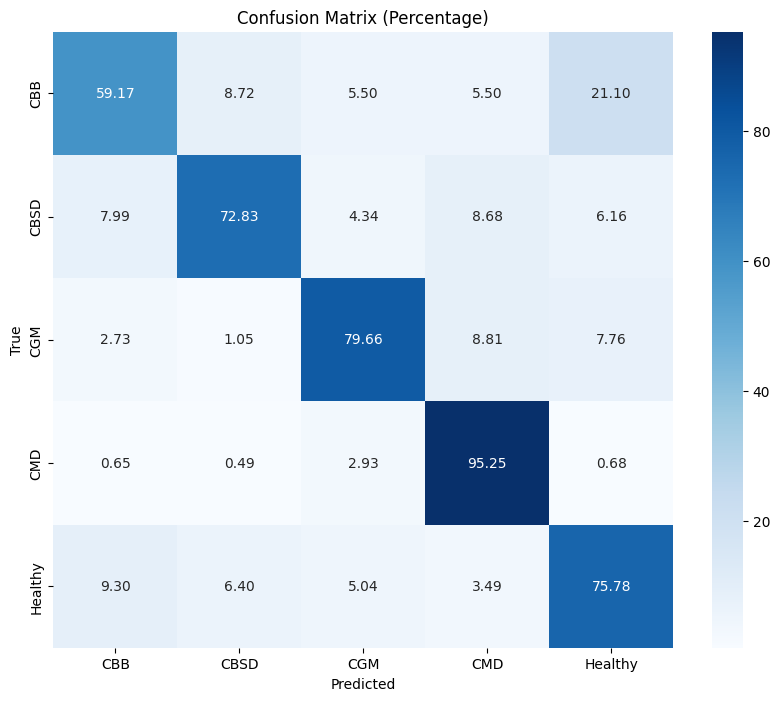

In [30]:
cm = confusion_matrix(true_classes, predicted_classes)

print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize the confusion matrix to percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Visualize the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()

